Muhammad Aizar Yazid / 1103223097

# Import Libraries

In [66]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
import warnings
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# EDA

In [67]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
data = pd.read_csv('/content/drive/MyDrive/RegresiUTSTelkom.csv')
print(data.head())  # Display the first few rows of the DataFrame

   2001  49.94357  21.47114   73.0775   8.74861  -17.40628  -13.09905  \
0  2001  48.73215  18.42930  70.32679  12.94636  -10.32437  -24.83777   
1  2001  50.95714  31.85602  55.81851  13.41693   -6.57898  -18.54940   
2  2001  48.24750  -1.89837  36.29772   2.58776    0.97170  -26.21683   
3  2001  50.97020  42.20998  67.09964   8.46791  -15.85279  -16.81409   
4  2001  50.54767   0.31568  92.35066  22.38696  -25.51870  -19.04928   

   -25.01202  -12.23257   7.83089  ...   13.0162  -54.40548  58.99367  \
0    8.76630   -0.92019  18.76548  ...   5.66812  -19.68073  33.04964   
1   -3.27872   -2.35035  16.07017  ...   3.03800   26.05866 -50.92779   
2    5.05097  -10.34124   3.55005  ...  34.57337 -171.70734 -16.96705   
3  -12.48207   -9.37636  12.63699  ...   9.92661  -55.95724  64.92712   
4   20.67345   -5.19943   3.63566  ...   6.59753  -50.69577  26.02574   

   15.37344   1.11144  -23.08793   68.40795  -1.82223  -27.46348   2.26327  
0  42.87836  -9.90378  -32.22788   70.49388  

In [69]:
print(data.info()) # Get a summary of the DataFrame, including data types and missing values
print(data.describe()) # Generate descriptive statistics for numerical columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515344 entries, 0 to 515343
Data columns (total 91 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   2001        515344 non-null  int64  
 1   49.94357    515344 non-null  float64
 2   21.47114    515344 non-null  float64
 3   73.0775     515344 non-null  float64
 4   8.74861     515344 non-null  float64
 5   -17.40628   515344 non-null  float64
 6   -13.09905   515344 non-null  float64
 7   -25.01202   515344 non-null  float64
 8   -12.23257   515344 non-null  float64
 9   7.83089     515344 non-null  float64
 10  -2.46783    515344 non-null  float64
 11  3.32136     515344 non-null  float64
 12  -2.31521    515344 non-null  float64
 13  10.20556    515344 non-null  float64
 14  611.10913   515344 non-null  float64
 15  951.0896    515344 non-null  float64
 16  698.11428   515344 non-null  float64
 17  408.98485   515344 non-null  float64
 18  383.70912   515344 non-null  float64
 19  32

In [70]:
# Number of duplicate rows
num_duplicates = data.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicates}")


Number of duplicate rows: 214


In [71]:
# Drop duplicate rows
data = data.drop_duplicates()

# Verify if duplicates are removed
num_duplicates = data.duplicated().sum()
print(f"\nNumber of duplicate rows after removal: {num_duplicates}")



Number of duplicate rows after removal: 0


In [72]:
data.isnull().sum()

,0
2001,0
49.94357,0
21.47114,0
73.0775,0
8.74861,0
...,...
-23.08793,0
68.40795,0
-1.82223,0
-27.46348,0


In [73]:
# Memindahkan kolom target '2001' ke posisi pertama
data = data[[data.columns[-1]] + [col for col in data.columns if col != data.columns[-1]]]
# Memisahkan fitur (X) dan target (y)
X = data.drop(columns=['2001'])  # Menghapus kolom target dari fitur
y = data['2001']  # Kolom '2001' sebagai target


In [74]:
y = data.iloc[:, 0]
X = data.iloc[:, 1:]

In [75]:
y_class = (y > y.median()).astype(int)

In [76]:
np.random.seed(42)
tf.random.set_seed(42)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns


In [78]:
# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features)
    ])

In [79]:
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [80]:
print("Original X_train shape:", X_train.shape)
print("Processed X_train shape:", X_train_processed.shape)
print("Original X_test shape:", X_test.shape)
print("Processed X_test shape:", X_test_processed.shape)

Original X_train shape: (412104, 90)
Processed X_train shape: (412104, 90)
Original X_test shape: (103026, 90)
Processed X_test shape: (103026, 90)


In [81]:
def regression_model(input):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse'
    )
    return model

r_model = regression_model(X_train_processed.shape[1])
r_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,017 (86.00 KB)

 Trainable params: 22,017 (86.00 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
# Define a checkpoint callback
checkpoint_path = "training_1/cp.ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train model with callbacks
history_reg = r_model.fit(
    X_train_processed, y_train,
    epochs=22,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=6,
            restore_best_weights=True
        ),
        cp_callback  # Include the checkpoint callback here
    ],
    verbose=1
)

Epoch 1/22
10302/10303 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 229.0906
Epoch 1: saving model to training_1/cp.ckpt.weights.h5
10303/10303 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - loss: 229.0808 - val_loss: 113.7520
Epoch 2/22
10293/10303 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 133.5536
Epoch 2: saving model to training_1/cp.ckpt.weights.h5
10303/10303 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 133.5495 - val_loss: 100.6427
Epoch 3/22
10282/10303 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 121.2003
Epoch 3: saving model to training_1/cp.ckpt.weights.h5
10303/10303 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 121.1993 - val_loss: 98.5228
Epoch 4/22
10290/10303 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 116.3740
Epoch 4: saving model to training_1/cp.ckpt.weights.h5
10303/10303 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 116.3717 - val_loss: 97.2011
Epoch 5/22
10297/10303 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 110.6446
Epoch 5: saving model to training_1/cp.ckpt.weights.h5
10303/10303 ━━━━━━━━━━━━━━

In [83]:

# Evaluate the regression model
y_pred = r_model.predict(X_test_processed)

mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")


3220/3220 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Mean Squared Error (MSE): 96.24310258722375
Root Mean Squared Error (RMSE): 9.810356904171416
R-squared (R2): 0.8009236045914625


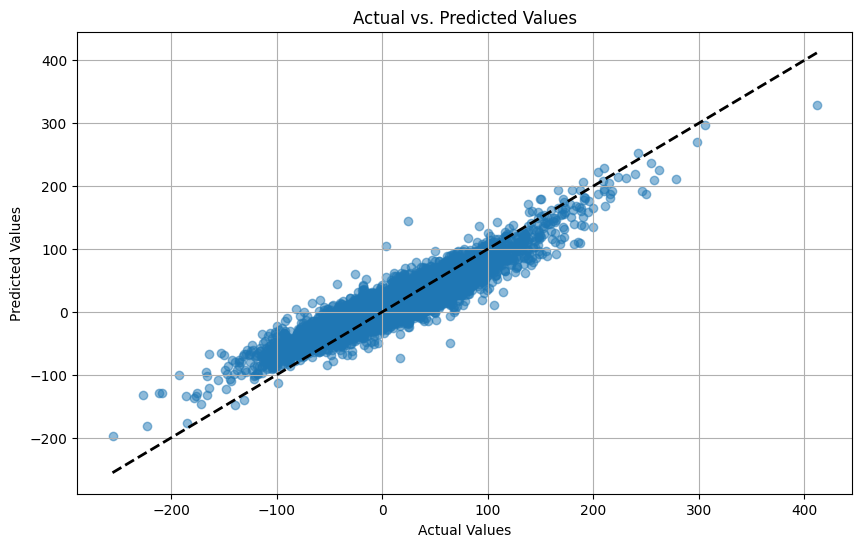

In [84]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()


              precision    recall  f1-score   support

           0       0.84      0.82      0.83     51393
           1       0.82      0.85      0.84     51633

    accuracy                           0.83    103026
   macro avg       0.83      0.83      0.83    103026
weighted avg       0.83      0.83      0.83    103026



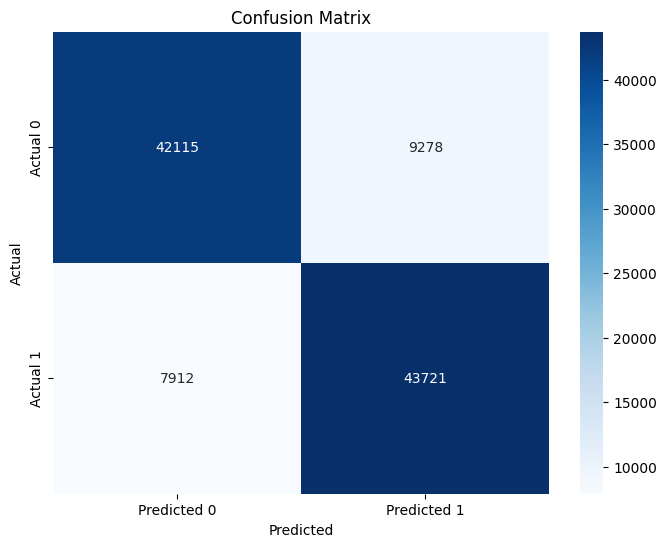

<ipython-input-85-e3ee06865031>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Value', data=metrics_df, palette="viridis")


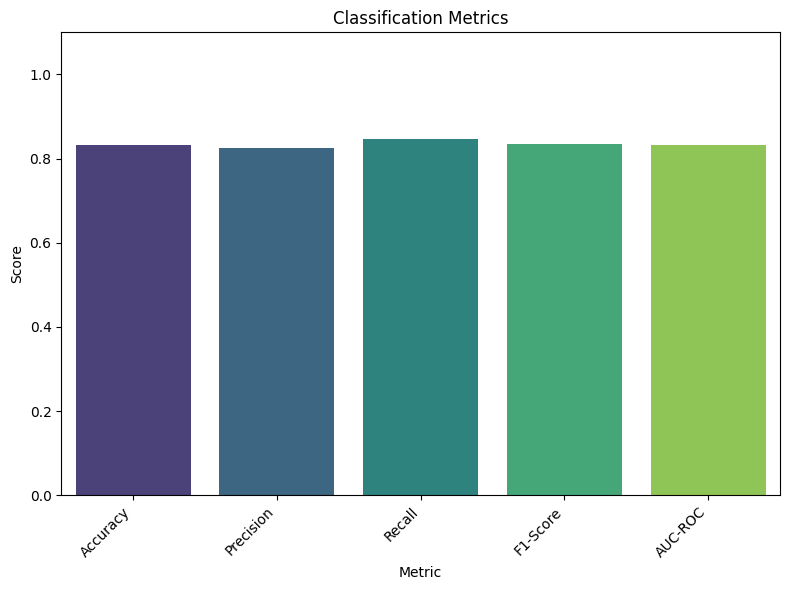

In [85]:
y_pred_class = (y_pred > y_test.median()).astype(int)


# Calculate evaluation metrics
accuracy = accuracy_score(y_class[X_test.index], y_pred_class)
precision = precision_score(y_class[X_test.index], y_pred_class)
recall = recall_score(y_class[X_test.index], y_pred_class)
f1 = f1_score(y_class[X_test.index], y_pred_class)

try:
  auc_roc = roc_auc_score(y_class[X_test.index], y_pred_class)
except ValueError:
  auc_roc = "undefined" # handle cases where AUC-ROC can't be computed

# Create a confusion matrix
cm = confusion_matrix(y_class[X_test.index], y_pred_class)


# Create a classification report
print(classification_report(y_class[X_test.index], y_pred_class))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Create a DataFrame for the evaluation metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
    'Value': [accuracy, precision, recall, f1, auc_roc]
})

# Visualize evaluation metrics
plt.figure(figsize=(8, 6))
sns.barplot(x='Metric', y='Value', data=metrics_df, palette="viridis")
plt.title('Classification Metrics')
plt.ylim(0, 1.1) # set y-axis limit to 0-1
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() # adjust layout to prevent labels from overlapping
plt.show()


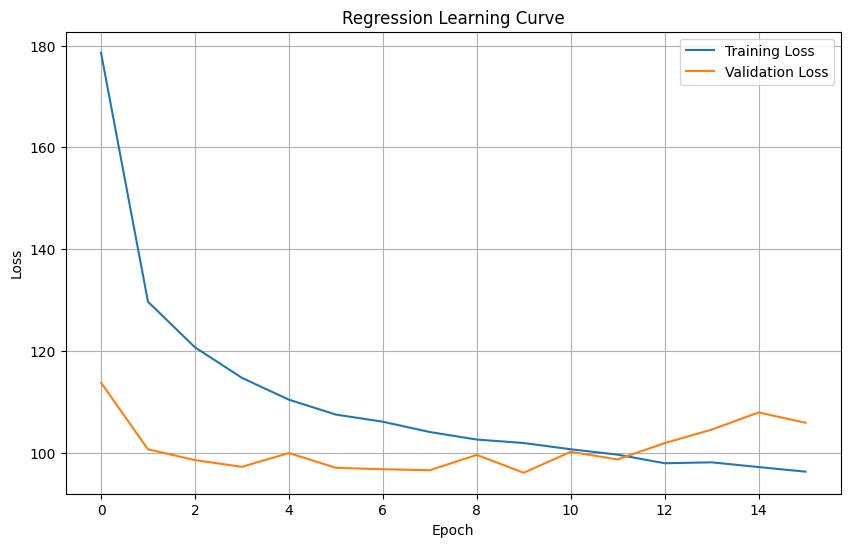

In [86]:
plt.figure(figsize=(10, 6))
plt.plot(history_reg.history['loss'], label='Training Loss')
plt.plot(history_reg.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Regression Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


In [88]:
# Create a dictionary to store the evaluation metrics
metrics_data = {
    'Metric': ['MSE', 'RMSE', 'R-squared', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
    'Value': [mse, rmse, r2, accuracy, precision, recall, f1, auc_roc]
}

# Create a DataFrame from the metrics dictionary
metrics_df = pd.DataFrame(metrics_data)

# Display the DataFrame
print(metrics_df)

if r2 > 0.7: #example threshold, adjust to your needs
  print("\nThe current model shows promising performance based on R-squared.")
else:
  print("\nThe current model's R-squared may require further improvement.")

      Metric      Value
0        MSE  96.243103
1       RMSE   9.810357
2  R-squared   0.800924
3   Accuracy   0.833149
4  Precision   0.824940
5     Recall   0.846765
6   F1-Score   0.835710
7    AUC-ROC   0.833117

The current model shows promising performance based on R-squared.


# Analisis

# Modifikasi Arsitektur MLP untuk Mengatasi Underfitting

Jika model MLP (256-128-64) mengalami underfitting, ada beberapa modifikasi yang bisa dilakukan untuk meningkatkan kapasitas model dalam menangkap pola lebih kompleks.

## Modifikasi yang Diusulkan:

- **Meningkatkan jumlah neuron dan layer:** Misalnya, ubah menjadi arsitektur (512-256-128) atau bahkan lebih. Penambahan neuron atau layer dapat memperbesar kapasitas model untuk menangkap kompleksitas data. Namun, perubahan ini harus diimbangi dengan perhatian terhadap regularisasi untuk menghindari overfitting.

- **Mengurangi regularisasi:** Dropout atau L2 regularization yang terlalu kuat bisa mengurangi kemampuan model untuk belajar. Menurunkan tingkat dropout atau L2 regularization memungkinkan model untuk belajar lebih banyak tentang data, meskipun harus dipantau agar tidak menyebabkan overfitting.

- **Menggunakan aktivasi yang lebih kompleks:** Aktivasi seperti Leaky ReLU, yang mengatasi masalah vanishing gradient, dapat memperbaiki proses pelatihan pada lapisan-lapisan tertentu.

- **Modifikasi Optimizer:** Menggunakan optimizers seperti Adam atau meningkatkan learning rate dapat mempercepat konvergensi. Jika learning rate terlalu kecil, pelatihan akan lambat dan cenderung underfitting, sedangkan learning rate yang terlalu besar dapat menyebabkan ketidakstabilan.

## Alasan perubahan berdasarkan Bias-Variance Tradeoff:

- **Underfitting menunjukkan bias yang tinggi dan variance yang rendah.**
  - **Penambahan neuron/layer mengurangi bias** dengan meningkatkan kapasitas model untuk menangkap pola data yang lebih kompleks.
  - **Mengurangi regularisasi** membantu model untuk lebih bebas dalam belajar, meskipun meningkatkan risiko overfitting.
  - **Aktivasi non-linear yang lebih kompleks** seperti Leaky ReLU membantu model untuk belajar dengan lebih efisien pada layer terdalam.
  - **Optimizer yang lebih efisien** mengurangi bias dengan memungkinkan model untuk menemukan solusi yang lebih baik lebih cepat.

**Keseimbangan** antara kapasitas model dan regularisasi sangat penting untuk menghindari overfitting sekaligus memastikan model dapat menangani data yang lebih kompleks.

---

# Alternatif Loss Function

Selain Mean Squared Error (MSE), ada beberapa loss function yang bisa lebih sesuai tergantung pada karakteristik dataset.

## Mean Absolute Error (MAE):
- **Kelebihan:** MAE tidak terlalu dipengaruhi oleh outlier, menjadikannya lebih robust ketika data mengandung noise atau distribusi yang sangat berbeda.
- **Kekurangan:** MAE menghasilkan gradien konstan, yang bisa membuat proses konvergensi menjadi lebih lambat, terutama pada data dengan variasi kecil antara prediksi dan nilai aktual.
- **Situasi lebih unggul:** Jika dataset memiliki outlier besar atau noise yang signifikan, MAE lebih baik karena tidak memberikan penalti besar terhadap error besar seperti MSE.

## Huber Loss:
- **Kelebihan:** Huber Loss adalah gabungan dari MSE dan MAE, sehingga dapat menangani outlier dengan lebih baik daripada MSE, namun tetap mempertahankan kehalusan gradien yang lebih baik daripada MAE.
- **Kekurangan:** Memerlukan pemilihan parameter delta yang baik agar bekerja optimal pada dataset tertentu.
- **Situasi lebih unggul:** Jika dataset mengandung kombinasi antara noise dan outliers, Huber Loss bisa menjadi pilihan terbaik karena dapat menangani keduanya.

## Log-Cosh Loss:
- **Kelebihan:** Log-Cosh Loss menggabungkan kelebihan MSE dan MAE, memberikan gradien yang lebih stabil dan konvergensi yang lebih baik.
- **Kekurangan:** Komputasi lebih rumit dibandingkan dengan MSE.
- **Situasi lebih unggul:** Dapat digunakan ketika dataset berisi nilai normal tetapi juga mengandung beberapa outliers.

---

# Pengaruh Perbedaan Skala Fitur (0-1 vs 100-1000)

Ketika dataset memiliki fitur dengan skala yang sangat berbeda (misalnya, fitur A dalam rentang 0-1 dan fitur B dalam rentang 100-1000), hal ini dapat berdampak signifikan terhadap pelatihan MLP.

## Mekanisme yang Terdampak:

- **Gradien:** Fitur dengan rentang besar (misalnya 100-1000) akan menghasilkan gradien yang lebih besar. Ini dapat menyebabkan pembaruan bobot yang lebih besar pada fitur tersebut, mengarah pada ketidakstabilan dalam proses pelatihan.
  
- **Pembaharuan Bobot:** Pembaruan bobot untuk fitur dengan skala besar akan lebih cepat, sementara fitur dengan skala kecil akan mengalami pembaruan bobot yang lebih lambat, yang bisa menyebabkan model menjadi bias terhadap fitur dengan skala besar.

- **Dominasi Fitur:** Fitur dengan rentang besar mendominasi proses perhitungan dalam hidden layer, yang dapat menyebabkan model hanya fokus pada fitur tersebut dan mengabaikan fitur lainnya.

## Dampak:
- **Konvergensi lambat atau gagal** karena ketidakstabilan dalam pembaruan bobot.
- **Bias terhadap fitur dengan skala besar**, yang bisa mempengaruhi akurasi model.
- **Stabilitas numerik berkurang**, membuat model lebih sensitif terhadap fluktuasi pembaruan bobot.

## Solusi:
- Gunakan teknik **normalisasi** atau **standardisasi** fitur untuk memastikan bahwa semua fitur berada dalam rentang yang seragam, sehingga gradien dan pembaruan bobot menjadi lebih seimbang.

---

# Mengukur Kontribusi Fitur

Untuk mengukur kontribusi relatif dari setiap fitur terhadap prediksi model, beberapa metode dapat digunakan. Masing-masing memiliki kekuatan dan keterbatasan.

## Permutation Importance:
- **Metodologi:** Dengan mengacak nilai dari suatu fitur dan mengukur penurunan skor model, kita dapat menilai seberapa penting fitur tersebut. Fitur yang penting akan menyebabkan penurunan besar dalam kinerja model saat nilai fitur diacak.
- **Keterbatasan:** Tidak menangkap interaksi kompleks antar fitur dan memerlukan banyak perhitungan, sehingga komputasi mahal.

## Weight Analysis:
- **Metodologi:** Dalam model linier atau MLP, kontribusi fitur dapat diukur dengan menganalisis bobot yang terkait dengan fitur. Bobot yang lebih besar menunjukkan kontribusi yang lebih besar terhadap prediksi.
- **Keterbatasan:** Metode ini sederhana dan tidak mempertimbangkan interaksi antar fitur.

## SHAP Values:
- **Metodologi:** SHAP (Shapley Additive Explanations) menghitung kontribusi marginal dari setiap fitur untuk setiap prediksi, memberikan penjelasan yang lebih terperinci untuk model kompleks.
- **Keterbatasan:** Memerlukan komputasi intensif dan interpretasi yang lebih kompleks.

---

# Desain Eksperimen untuk Learning Rate dan Batch Size

Untuk memilih learning rate dan batch size secara optimal, kita bisa merancang eksperimen dengan beberapa pendekatan.

## Learning Rate Range Test:
Mulailah dengan nilai learning rate yang kecil, kemudian secara bertahap meningkatkannya untuk menemukan rentang optimal.

## Grid Search atau Random Search:
Uji berbagai kombinasi learning rate dan batch size dengan validasi silang untuk menemukan yang terbaik.

## Learning Rate Schedulers:
Gunakan scheduler seperti **Exponential Decay** atau **Cyclic Learning Rate** untuk mengoptimalkan learning rate selama pelatihan.

### Analisis Tradeoff:

- **Learning Rate (LR):**
  - **LR besar:** Cepat mempercepat konvergensi, tetapi bisa menyebabkan divergensi dan ketidakstabilan.
  - **LR kecil:** Lebih stabil tetapi proses konvergensi lebih lambat.

- **Batch Size:**
  - **Batch size kecil:** Memperbarui bobot lebih sering, namun lebih berisiko terhadap overfitting dan lebih bising.
  - **Batch size besar:** Lebih efisien dalam estimasi gradien, tetapi memerlukan lebih banyak memori dan bisa lebih lambat dalam pembaruan bobot.

## Strategi:
- Gunakan **adaptive optimizers** seperti Adam yang menyesuaikan learning rate secara otomatis dan eksperimen dengan **batch size kecil** untuk mengurangi waktu pelatihan, sambil menjaga stabilitas model.

Dengan modifikasi dan eksperimen yang tepat, model dapat mencapai keseimbangan yang baik antara efisiensi komputasi, stabilitas pelatihan, dan performa yang optimal.
